<a href="https://colab.research.google.com/github/Chamal-Dakshana/DL_Assignment/blob/IT20089054/IT20089054.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pytesseract

In [ ]:
import cv2 #importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image
plt.style.use('dark_background')

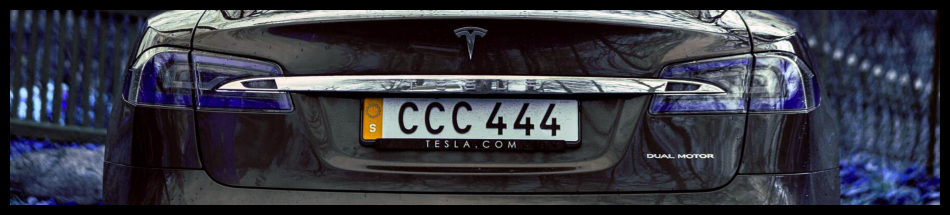

In [ ]:
img_ori = cv2.imread('/content/dataset-cover.jpg')

height, width, channel = img_ori.shape

plt.figure(figsize=(12, 10))                   #Create a Matplotlib figure
plt.imshow(img_ori, cmap='gray')
plt.axis('off')                                #Turn off the axis labels
plt.savefig('Car.png',bbox_inches = 'tight')
plt.show()


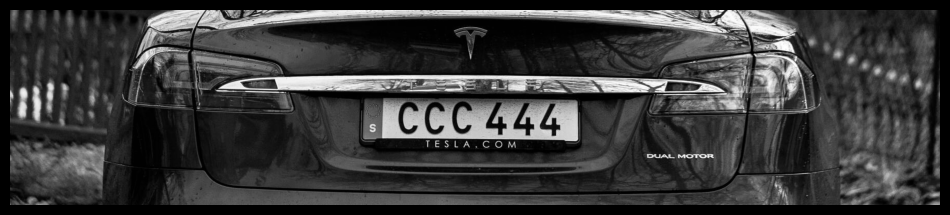

In [ ]:
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)  #convert whole image to gray

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.savefig('Car-GrayScale.png',bbox_inches = 'tight')
plt.show()

In [ ]:
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  #structuring element using a 3x3 rectangular kernel

imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

In [ ]:
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0) #applies Gaussian blur to the grayscale image

img_thresh = cv2.adaptiveThreshold(
    img_blurred, #input image after Gaussian blurring
    maxValue=255.0, #maximum pixel value for the output binary image
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19,
    C=9 #threshold value for each pixel.
)

In [ ]:
contours, _= cv2.findContours(
    img_thresh, #input binary image
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

array([[[255, 255, 255],
        [255, 255, 255],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 255, 255],
        [255, 255, 255],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 255, 255],
        [255, 255, 255],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [ ]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)

    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

In [ ]:
MIN_AREA = 80 #Minimum area (pixel count)
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']

    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)


temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:

    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

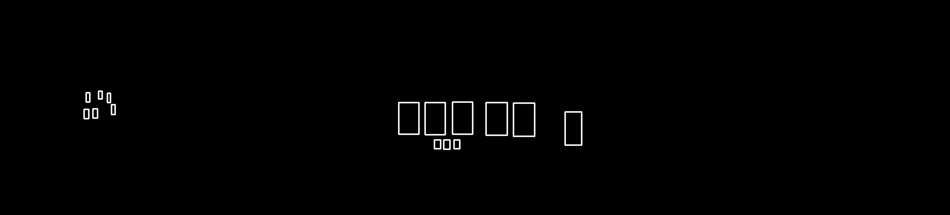

In [ ]:
MAX_DIAG_MULTIPLYER = 5 #diagonal multiplie
MAX_ANGLE_DIFF = 12.0
MAX_AREA_DIFF = 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3

def find_chars(contour_list):
    matched_result_idx = []

    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])


        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)


        recursive_contour_list = find_chars(unmatched_contour)

        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx

result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))


temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:

        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
plt.savefig('Car-Boxes-byContourArrangement.png',bbox_inches = 'tight')
plt.show()

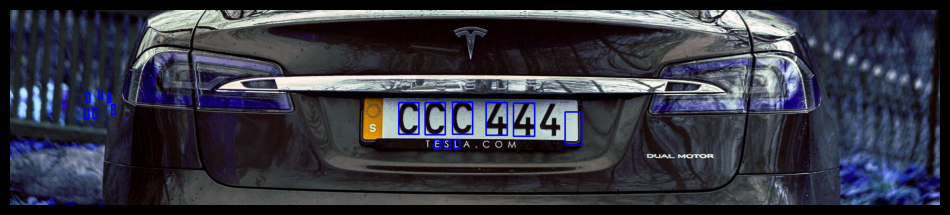

In [ ]:
result_idx = find_chars(possible_contours)

matched_result = []  #create empty list
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        #cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(img_ori, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(0, 0, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(img_ori, cmap='gray')
plt.axis('off')
plt.savefig('Car-OverlappingBoxes.png',bbox_inches = 'tight')
plt.show()

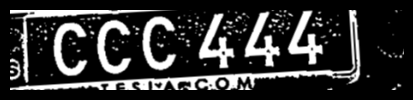

In [ ]:
PLATE_WIDTH_PADDING = 1.3
PLATE_HEIGHT_PADDING = 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2

    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING

    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)

    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) -
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )

    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))

    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)

    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))

    img_cropped = cv2.getRectSubPix(
        img_rotated,
        patchSize=(int(plate_width), int(plate_height)),
        center=(int(plate_cx), int(plate_cy))
    )

    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue

    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })

    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')
    plt.axis('off')
    plt.savefig('Car-Plates(Rotated).png',bbox_inches = 'tight')
    plt.show()

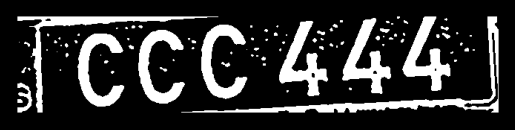

In [ ]:
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)


    contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)

    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h

    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]

    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')
    plt.axis('off')
    plt.savefig('Car-Plates(Thresholding).png',bbox_inches = 'tight')
    plt.show()
    break

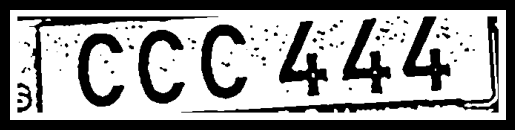

In [ ]:
img = 255-img_result
plt.imshow(img, 'gray')
plt.axis('off')
plt.savefig('Car-Plates(Negative).png',bbox_inches = 'tight')
plt.show()


In [ ]:
def find_contours(dimensions, img) :


    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # Find all contours in the image


    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]


    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15] # Check largest 5 or  15 contours for license plate or character

    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :

        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)


        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX)

            char_copy = np.zeros((44,24))

            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.axis('off')


            char = cv2.subtract(255, char)


            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy)



    plt.show()

    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])
    img_res = np.array(img_res_copy)

    return img_res

In [ ]:

def segment_characters(image) :


    img_lp = cv2.resize(image, (333, 75))

    LP_WIDTH = img_lp.shape[0]
    LP_HEIGHT = img_lp.shape[1]

    # Make borders white
    img_lp[0:3,:] = 255
    img_lp[:,0:3] = 255
    img_lp[72:75,:] = 255
    img_lp[:,330:333] = 255

    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_lp, cmap='gray')
    plt.axis('off')
    plt.show()
    cv2.imwrite('contour.jpg', img_lp)



    char_list = find_contours(dimensions, img_lp)

    return char_list

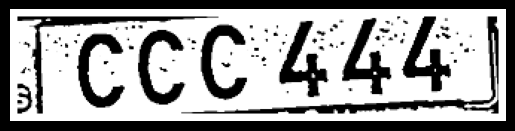

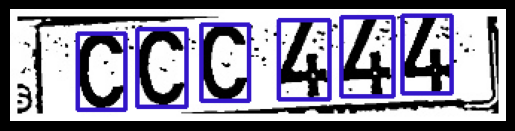

In [ ]:
char = segment_characters(img)

In [ ]:
plt.style.use('ggplot') #changed the style of plots

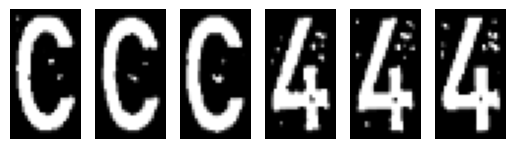

In [ ]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.savefig('Car-Plates-Char(Seperated).png',bbox_inches = 'tight')

In [ ]:
import tensorflow as tf
from sklearn.metrics import f1_score
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from keras.models import Sequential,model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
import tensorflow.keras.backend as K

In [ ]:
! unzip archive_2

Archive:  archive_2.zip
replace data/train/class_0/class_0_10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = '/content/data'
train_generator = train_datagen.flow_from_directory(
        path+'/train',
        target_size=(28,28),
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',
        target_size=(28,28),
        class_mode='sparse')

In [ ]:
def f1score(y, y_pred):
    return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro')

def custom_f1score(y, y_pred):
    return tf.py_function(f1score, (y, y_pred), tf.double)

In [ ]:
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")

def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./{}.h5".format(model_name))
    return model

In [ ]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(4,4)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=[custom_f1score])

In [ ]:
model.summary()

In [ ]:
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_custom_f1score') > 0.99):
              self.model.stop_training = True

In [ ]:
batch_size = 1
callbacks = [stop_training_callback()]
model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator,
      epochs = 20, verbose=1, callbacks=callbacks)

In [ ]:
store_keras_model(model, 'model_LicensePlate')

In [ ]:
pre_trained_model = load_keras_model('model_LicensePlate')
model = pre_trained_model

In [ ]:
print(pre_trained_model.summary())

In [ ]:
def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img

def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for i, ch in enumerate(char):  # iterating over the characters
        img_ = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1, 28, 28, 3)  # preparing image for the model
        y_prob = model.predict(img)[0]  # predicting probabilities for all classes
        y_class = np.argmax(y_prob)  # finding the class with the highest probability
        character = dic[y_class]
        output.append(character)  # storing the result in a list

    plate_number = ''.join(output)

    return plate_number

print(show_results())

In [ ]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    title_obj = plt.title(f'predicted: {show_results()[i]}')
    plt.setp(title_obj, color='black')
    plt.axis('off')
plt.show()

In [ ]:
!apt-get install -y tesseract-ocr

In [ ]:
!pip install pytesseract

In [ ]:
import pytesseract
from PIL import Image

In [ ]:
pytesseract.pytesseract.tesseract_cmd = 'C:\Program Files\Tesseract-OCR'  # Update with the correct path on Colab


In [ ]:
char = segment_characters(img_result)

In [ ]:
txt = ''

for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    img_1 = Image.fromarray(char[i])
    img_1 = img_1.convert("RGB")
    txt += pytesseract.image_to_string(img_1, lang='eng', config='--psm 6')[0]
    plt.axis('off')

print(txt)